### Web Intelligence - Exercise 10

In this exercise, we will explore several prominent techniques for learning word representations. First, we will implement a matrix decomposition-based word embedding model, **Latent Semantic Analysis (LSA)**. These models leverage matrix factorization to capture semantic relationships in text, providing an introduction to the underlying principles of word representation.

Next, we will implement a neural-based approach, the **SkipGram** model of the **Word2Vec** framework. The SkipGram architecture is designed to predict surrounding context words given a target word, effectively learning word representations that capture meaningful relationships between words in a corpus.

We will work on the [CMU Book Summary](https://www.cs.cmu.edu/~dbamman/booksummaries.html) dataset that consists of plot summaries for $16,559$ books extracted from Wikipedia. Throughout the exercise, we will analyze and compare these methods, discussing their advantages, limitations, and practical applications in natural language processing tasks. 

**Question 1.** In this exercise, we will implement the Latent Semantic Analysis (LSA).

In [1]:
import os.path

from tqdm.notebook import tqdm
# For loading the dataset
from datasets import load_dataset

# Preprocessing packages
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Load the dataset and preprocess the book summaries.

In [2]:
# Load the CMU Book Summary Corpus dataset and get all the summaries.
ld = load_dataset("textminr/cmu-book-summaries")['train']
summaries = [data['summary'] for data in ld]

In [3]:
# Complete the following preprocessing steps:
stop_words = set(stopwords.words("english"))

def preprocess_texts(texts, stop_words):
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    cleaned_texts = []
    for text in tqdm(texts, desc="Pre-processing text"):
        
        # 1. Lowercase the text
        text = text.lower()
        
        # 3. Remove punctuation and special characters
        text = re.sub(r"[^a-z\s]", "", text)
        
        # 4. Tokenize the text
        words = word_tokenize(text)
        
        # 5. Remove stopwords
        words = [word for word in words if word not in stop_words]
        
        # 6. Lemmatize the tokens 
        words = [lemmatizer.lemmatize(word) for word in words]
        
        # Join tokens back into a single string
        cleaned_texts.append(" ".join(words))
        
    return cleaned_texts

# Run the preprocessing function on the summaries
corpus = preprocess_texts(summaries, stop_words=stop_words)

Pre-processing text:   0%|          | 0/16559 [00:00<?, ?it/s]

In [4]:

# You can compare the original and preprocessed summaries to see the difference.
print(f"Original: {summaries[0][:100]}")
print(f"Preprocessed: {corpus[0][:100]}")

Original:  Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he co
Preprocessed: old major old boar manor farm call animal farm meeting compare human parasite teach animal revolutio


Construct the Document-Term Matrix

In [5]:

# Note: you can only consider the top 'N' words ordered by term frequency across the corpus.
from sklearn.feature_extraction.text import CountVectorizer

vocab_size = 10000

# Initialize the vectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=vocab_size)

# Fit and transform the vectorizer to the preprocessed corpus
dt_matrix = vectorizer.fit_transform(corpus)

# Get feature names (words)
terms = vectorizer.get_feature_names_out()
# Display the first few terms
print("\nTerms:\n", terms[:10])



Terms:
 ['aaron' 'abandon' 'abandoned' 'abandoning' 'abandonment' 'abbess' 'abbey'
 'abbot' 'abby' 'abducted']


Construct the Term Frequency-Inverse Document Frequency (TF-IDF) Weighting

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize the transformer
tfidf_transformer = TfidfTransformer()

# Fit and transform the document-term matrix to the TF-IDF matrix
tfidf_matrix = tfidf_transformer.fit_transform(dt_matrix)

# Display the first few terms
print("\nTF-IDF Matrix:\n", tfidf_matrix[:5])



TF-IDF Matrix:
   (0, 28)	0.04150504697109791
  (0, 59)	0.017880438439147568
  (0, 62)	0.024050614704513258
  (0, 65)	0.02148900220953582
  (0, 101)	0.019971252959796713
  (0, 106)	0.025405365080079376
  (0, 110)	0.023893419238681803
  (0, 144)	0.023427409569694274
  (0, 146)	0.028160637656986585
  (0, 249)	0.09254085191660141
  (0, 285)	0.020202945121143484
  (0, 294)	0.02759108894982344
  (0, 306)	0.024863156853871606
  (0, 382)	0.5899226349451504
  (0, 399)	0.03845058365259945
  (0, 448)	0.013862127897737705
  (0, 491)	0.015845144349549038
  (0, 499)	0.019013388868692853
  (0, 563)	0.021664340850956573
  (0, 598)	0.021980774729014246
  (0, 631)	0.012484875364678306
  (0, 636)	0.03216995352535589
  (0, 717)	0.010649333876096276
  (0, 831)	0.01343579505830276
  (0, 846)	0.042099843524759734
  :	:
  (4, 8803)	0.03212315565655537
  (4, 8806)	0.047354241570513426
  (4, 8826)	0.046643489355269636
  (4, 8836)	0.03794523028781552
  (4, 8847)	0.03692569007328962
  (4, 8967)	0.04647512558107

Perfom Singular Value Decomposition (SVD) and Dimensionality Reduction

In [7]:
k = 32

import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
U, S, Vh = svds(tfidf_matrix, k=k)

index = np.argsort(S)[::-1]
U, S, Vh = U[:, index], S[index], Vh[index]

# Print the singular values
print("\nTop k- singular values:\n", S)

# Define the word embeddings
# Note that the columns of SVh.T define the word embeddings, i.e. rows of the VhS
# SVh.T is also equal to U^TX so the rows of (X^TU) also correspond the same word embeddings.
word_embeddings = np.dot(np.diag(S), Vh).T



Top k- singular values:
 [17.82432879  7.94587596  6.97479132  6.25583585  5.92562977  5.66415625
  5.59209614  5.55013998  5.38315779  5.1758549   5.10314635  5.07500647
  4.96575891  4.92335685  4.8769072   4.82142292  4.79849963  4.77217133
  4.74419834  4.64729459  4.6247623   4.60609472  4.57410815  4.52926954
  4.51877933  4.4791294   4.46241974  4.44398562  4.43039021  4.39791334
  4.36031844  4.34162853]


Generate Word Embeddings and Analyze Similarity Between Words

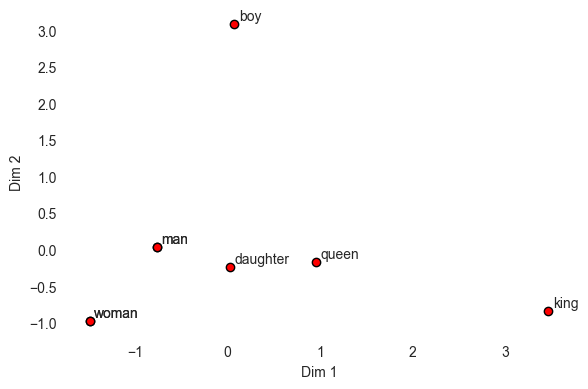

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

words_to_explore= [
    'king', 'queen', 'woman', 'man', 'man', 'woman', 'boy', 'daughter', 
    #'dog', 'cat', 'horse', 'elephant', 'fish', 'bird', 'lizard', 'snake',
    #'doctor', 'nurse', 'scientist', 'teacher', 'engineer', 'artist', 'musician', 'writer',
    #'denmark', 'sweden', 'france', 'germany', 'spain', 'italy', 'portugal', 'turkey',
]
selected_ids = [vectorizer.vocabulary_[word] for word in words_to_explore]
selected_word_embeddings = word_embeddings[selected_ids, :]
# Visualize the word embeddings using t-SNE or PCA for dimensionality reduction to 2D
#tsne = TSNE(n_components=2, random_state=0)
#projected_embs = tsne.fit_transform(selected_word_embeddings)
pca = PCA(n_components=2)
projected_embs = pca.fit_transform(selected_word_embeddings)[:,:2]


# Visualize the word embeddings using PCA for dimensionality reduction to 2D
projected_embs = PCA(n_components=2).fit_transform(selected_word_embeddings)[:,:2]

plt.figure(figsize=(6,4), frameon=False)
plt.scatter(projected_embs[:,0], projected_embs[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words_to_explore, projected_embs):
    plt.text(x+0.05, y+0.05, word)
plt.xlabel('Dim 1', fontsize=10)
plt.ylabel('Dim 2', fontsize=10)
plt.tight_layout()
plt.box(False)
plt.show()



In [9]:
# Analyzing similarity between words
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_terms(word1, word2, word_embeddings_df):
    vec1 = word_embeddings_df.loc[word1].values.reshape(1, -1)
    vec2 = word_embeddings_df.loc[word2].values.reshape(1, -1)
    similarity = cosine_similarity(vec1, vec2)
    return similarity[0][0]

# Find top 5 similar words for a given word
def top_similar_words(word, word_embeddings_df, terms, top_n=5):
    target_vector = word_embeddings_df.loc[word].values.reshape(1, -1)
    similarities = cosine_similarity(word_embeddings_df, target_vector).flatten()
    top_indices = np.argsort(similarities)[-top_n-1:-1][::-1]  # Exclude the word itself
    similar_words = [(terms[i], similarities[i]) for i in top_indices]
    return similar_words

word_embeddings_df = pd.DataFrame(word_embeddings, index=terms)

word1, word2 = "king", "queen"
# Test cosine similarity function
print(f"Cosine similarity between '{word1}' and '{word2}': {cosine_similarity_terms(word1, word2, word_embeddings_df)}")
word = "king"
print(f"Top 5 similar words to '{word}': {top_similar_words(word, word_embeddings_df, terms, top_n=5)}")

Cosine similarity between 'king' and 'queen': 0.9401573365154285
Top 5 similar words to 'king': [('coronation', 0.9438202898157546), ('queen', 0.9401573365154285), ('throne', 0.9365763575686025), ('crowned', 0.934686036005121), ('rhemuth', 0.9269274741745209)]


Compare Book Summaries

In [10]:
# Define the book summary vectors
doc_embedding = U

# Compute cosine similarity between documents
doc_similarities = cosine_similarity(doc_embedding)
doc_similarities_df = pd.DataFrame(
    doc_similarities, columns=[f"Summary {i+1}" for i in range(len(corpus))], index=[f"Summary {i+1}" for i in range(len(corpus))])

print("\nSummary Similarities (Cosine Similarity):\n", doc_similarities_df)


Summary Similarities (Cosine Similarity):
                Summary 1  Summary 2  Summary 3  Summary 4  Summary 5  \
Summary 1       1.000000  -0.036871   0.395550   0.318123  -0.015009   
Summary 2      -0.036871   1.000000  -0.007497   0.143525   0.074623   
Summary 3       0.395550  -0.007497   1.000000   0.065269  -0.144059   
Summary 4       0.318123   0.143525   0.065269   1.000000   0.282950   
Summary 5      -0.015009   0.074623  -0.144059   0.282950   1.000000   
...                  ...        ...        ...        ...        ...   
Summary 16555  -0.097693  -0.019470   0.164275   0.120111   0.227327   
Summary 16556   0.327779   0.351161   0.354324  -0.106347  -0.296311   
Summary 16557  -0.077746   0.101362  -0.025403   0.136211   0.009688   
Summary 16558   0.220101   0.017644   0.300007   0.220255  -0.238999   
Summary 16559   0.039455   0.084514   0.156596  -0.008125  -0.120293   

               Summary 6  Summary 7  Summary 8  Summary 9  Summary 10  ...  \
Summary 1    

**Question 2.** In this exercise, you will explore pre-trained word embeddings on the [Google News dataset](https://code.google.com/archive/p/word2vec/), and you will familiarize yourself with the **Gensim** package for handling the word embeddings. You will also investigate the analogy relationships between words based on their embeddings.

In [11]:
import os
import numpy as np
import gensim
from gensim.test.utils import datapath
from sklearn.decomposition import PCA


Download the pre-trained word embeddings from [Google News dataset](https://code.google.com/archive/p/word2vec/) and use the *Gensim* package to load and work with the embeddings.

In [12]:
# Define the path of the pretrained model
googlenews_vectors = os.path.realpath(os.path.join(
    os.getcwd(), './GoogleNews-vectors-negative300.bin.gz'
))
gensim_model = gensim.models.KeyedVectors.load_word2vec_format(googlenews_vectors, binary = True)

 Use the following example list of words: 'king', 'queen', 'woman', 'man', 'fish', 'bird', 'snake', 'elephant' (or construct your own list of at least $6$-$10$ meaningful and diverse words.

Reduce the dimensionality of the word embeddings to $2D$ space using PCA and visualize the words in the new latent space.

In [13]:

def display_pca_scatterplot(model, words=None, sample=0, save=False, file_path='scatterplot.png'):
    ### Inspired by the WI materials in 2023 and by http://web.stanford.edu/class/cs224n/
    
    assert words is None or sample == 0, f"You must specify either words or sample, not both"
    
    if words is None:
        words = [ word for word in model.key_to_index.keys() ]
    if sample > 0:
        words = np.random.choice(list(model.key_to_index.keys()), sample)
        
    word_vectors = np.array([model[w] for w in words])

    projected_embs = PCA(n_components=2).fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,4), frameon=False)
    plt.scatter(projected_embs[:,0], projected_embs[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, projected_embs):
        plt.text(x+0.05, y+0.05, word)
    plt.xlabel('Dim 1', fontsize=10)
    plt.ylabel('Dim 2', fontsize=10)
    plt.tight_layout()
    plt.box(False)
    if save:
        plt.savefig(file_path)
    else:
        plt.show()


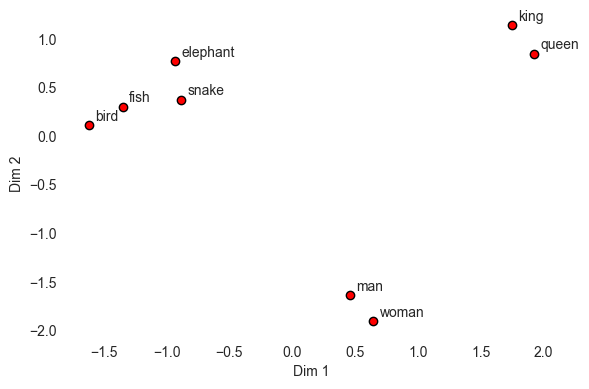

In [14]:
words_to_explore= [
    'king', 'queen', 'woman', 'man', 'fish', 'bird', 'snake', 'elephant',
]
display_pca_scatterplot(model=gensim_model, words=words_to_explore)


Investigate the relationships between the words based on their embeddings.

In [15]:
gensim_model.most_similar(positive=["king", "woman"],negative=["man"])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

Assess the overall accuracy of the embeddings and analyze strengths and weaknesses across analogy types (syntactic vs. semantic).


In [16]:
# print("Current Working Directory:", datapath('./questions-words.txt'))

accuracy = gensim_model.evaluate_word_analogies(datapath('./questions-words.txt'), dummy4unknown=True)



# The first entry stores the overall evaluation score on the entire evaluation set
print(f"Overall evaluation score: {accuracy[0]}")
for current_dict in accuracy[1]:
    correct_count, incorrect_count = len(current_dict['correct']), len(current_dict['incorrect'])
    section_accuracy = correct_count / float(correct_count + incorrect_count)
    print(
        f"Section: {current_dict['section']} - Correct: {correct_count} - Incorrect: {incorrect_count} - Accuracy: {section_accuracy}"
    )

Overall evaluation score: 0.7320405239459681
Section: capital-common-countries - Correct: 421 - Incorrect: 85 - Accuracy: 0.8320158102766798
Section: capital-world - Correct: 3552 - Incorrect: 972 - Accuracy: 0.7851458885941645
Section: currency - Correct: 230 - Incorrect: 636 - Accuracy: 0.26558891454965355
Section: city-in-state - Correct: 1779 - Incorrect: 688 - Accuracy: 0.72111876773409
Section: family - Correct: 436 - Incorrect: 70 - Accuracy: 0.8616600790513834
Section: gram1-adjective-to-adverb - Correct: 290 - Incorrect: 702 - Accuracy: 0.2923387096774194
Section: gram2-opposite - Correct: 353 - Incorrect: 459 - Accuracy: 0.43472906403940886
Section: gram3-comparative - Correct: 1216 - Incorrect: 116 - Accuracy: 0.9129129129129129
Section: gram4-superlative - Correct: 987 - Incorrect: 135 - Accuracy: 0.8796791443850267
Section: gram5-present-participle - Correct: 829 - Incorrect: 227 - Accuracy: 0.7850378787878788
Section: gram6-nationality-adjective - Correct: 1442 - Incorrec

**Question 3.** In this exercise, we will implement the **SkipGram** model of the **Word2Vec** framework.

In [17]:
# Import the necessary packages
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

Prepare the training data

In [18]:
corpus = corpus # Define the corpus (preprocessed summaries)


In [19]:
min_count = 5 # Discard the words that appear less or equal to 'min_count'
window_size = 5 # You can choose small values to reduce computational cost, but it might affect the performance of the model

from collections import Counter
sentences = [sentence.split() for sentence in corpus]
list_of_words = [word for sentence in sentences for word in sentence]
vocab = set(list_of_words) 
word_counts = Counter(list_of_words)

# Define the vocabulary, i.e. set of all distinct words that appear more than 'min_count' times in the corpus.
vocab = set([word for word in vocab if word_counts[word] > min_count]) 
vocab_size = len(vocab) 
# Construct the dictionaries that maps words to unique ids and vice versa.
word2Id = {word: id for id, word in enumerate(vocab)}
id2Word = {id: word for word, id in word2Id.items()}



In [20]:
# Generate skip-gram training (source, context) word pairs.

# You can implement the following function to generate the source-context word pairs.
# If you wish, you can also modify the argument list
def generate_center_context_pairs(sentences, window_size, word2Id, vocab):
    '''
    Given a list of sentences and a window size, generate a pair of context pairs
    Note that a pair must be discarded if its center or context word appears less than 'min_count'.
    :param sentences: a list of lists of words
    :param window_size: window size
    :param word2Id: a dictionary that maps words to ids
    :param vocab: a set of unique words
    :return: a list of centerId-contextId word pairs
    '''
    data = []
    for sentence in tqdm(sentences, desc="Generating center-context pairs"):
        for i, word in enumerate(sentence):
            if word in vocab:
                center_word_id = word2Id[word]
                context_words = [sentence[i + j] for j in range(-window_size, window_size + 1) if j != 0 and 0 <= i + j < len(sentence)]
                for context_word in context_words:
                    if context_word in vocab:
                        context_word_id = word2Id[context_word]
                        data.append((center_word_id, context_word_id))
                    #pass
    return data

pairs = generate_center_context_pairs(sentences=sentences, window_size=window_size, word2Id=word2Id, vocab=vocab)
# Convert the list to a torch tensor
pairs = torch.as_tensor(pairs, dtype=torch.long)

Generating center-context pairs:   0%|          | 0/16559 [00:00<?, ?it/s]

In [21]:
# You can examine the training data
print(f"Vocab size: {vocab_size}")
print(f"Number of center-context pairs: {pairs.shape[0]}")

Vocab size: 38312
Number of center-context pairs: 34393094


Implement the SkipGram Model with Softmax Function

In [22]:
# Define the Skip-gram Model with Softmax
class SkipGramModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_dim)
        self.linear = torch.nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, center_word):
        # Embedding layer
        embedding = self.embeddings(center_word)
        # Linear layer with softmax for prediction
        output = self.linear(embedding)
        return output
    
    def get_center_embs(self, center_words = None):
        if center_words is None:
            return self.embeddings.weight
        else:
            return self.embeddings.weight.data[center_words]
    
    def get_context_embs(self, context_words):
        if context_words is None:
            return self.linear.weight
        else:
            return self.linear.weight.data[context_words, :]

Set the parameters required for training the model such as learning rate, embedding dimension, epochs and batch size.
Note that chosen values for the parameters might/might not affect the optimization and the training time.

In [25]:
lr = 0.01
epochs_num = 1
embedding_dim = 100
batch_size = 5000
# batch_size = 512 
# The batch size refers to the number of training examples processed together in a single forward and backward pass during training. It determines how much data is used at once to compute gradients and update model parameters.

# Initialize model, loss, and optimizer
model = SkipGramModel(vocab_size, embedding_dim)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Set the platform that we will use for training.
device = torch.device('cpu') #torch.device("cuda" if torch.cuda.is_available() else "cpu") (for Mac M1/M2, torch.device('mps'))
model.to(device)

SkipGramModel(
  (embeddings): Embedding(38312, 100)
  (linear): Linear(in_features=100, out_features=38312, bias=True)
)

Train the model

In [26]:
# Build a data loader for pairs vector in pytorch
data_loader = DataLoader(pairs, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in tqdm(range(epochs_num)):
    total_loss = 0
    for batch_pairs in tqdm(data_loader, desc=f"Epoch {epoch} - Current batch progress"):
        # Transfer the batch data to the memory of the 'device' (i.e. gpu if used)
        batch_pairs = batch_pairs.to(device)
        # Define the center and context words
        center_word, context_word = batch_pairs[:, 0], batch_pairs[:, 1]
        
        # Forward pass
        optimizer.zero_grad()
        output = model(center_word)
        
        # Calculate loss
        loss = loss_function(output, context_word)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(pairs):.4f}")  
        
# Transfer the model back to the cpu.
model.to('cpu')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0 - Current batch progress:   0%|          | 0/6879 [00:00<?, ?it/s]

Exception ignored in: <generator object tqdm.__iter__ at 0x00000247EC606500>
Traceback (most recent call last):
  File "C:\Software\python\Web Intelligence\web-intelligence-course-sw7\venv\lib\site-packages\tqdm\std.py", line 1196, in __iter__
    self.close()
  File "C:\Software\python\Web Intelligence\web-intelligence-course-sw7\venv\lib\site-packages\tqdm\notebook.py", line 272, in close
    def close(self):
KeyboardInterrupt: 


KeyboardInterrupt: 

Generate Word Embeddings and Visualize

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

words_to_explore= [
    'king', 'queen', 'woman', 'man', 'boy', 'daughter', 
    'dog', 'cat', 'horse', 'elephant', #'fish', 'bird', 'lizard', 'snake',
    #'doctor', 'nurse', 'scientist', 'teacher', 'engineer', 'artist', 'musician', 'writer',
    #'denmark', 'sweden', 'france', 'germany', 'spain', 'italy', 'portugal', 'turkey',
]
selected_ids = torch.tensor([word2Id[word] for word in words_to_explore])
selected_word_embeddings = model.get_center_embs(selected_ids).detach()


# Visualize the word embeddings using PCA for dimensionality reduction to 2D
projected_embs = PCA(n_components=2).fit_transform(selected_word_embeddings)[:,:2]

plt.figure(figsize=(6,4), frameon=False)
plt.scatter(projected_embs[:,0], projected_embs[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words_to_explore, projected_embs):
    plt.text(x+0.05, y+0.05, word)
plt.xlabel('Dim 1', fontsize=10)
plt.ylabel('Dim 2', fontsize=10)
plt.tight_layout()
plt.box(False)
plt.show()


Evaluate Word Similarity

In [ ]:
names = [id2Word[i] for i in range(len(id2Word))]
word_embs_df = pd.DataFrame(model.get_center_embs().detach(), index=names)

word1, word2 = "king", "queen"
# Test cosine similarity function
print(f"Cosine similarity between '{word1}' and '{word2}': {cosine_similarity_terms(word1, word2, word_embs_df)}")
word = "king"
print(f"Top 5 similar words to '{word}': {top_similar_words(word, word_embs_df, names, top_n=5)}")

